<a href="https://colab.research.google.com/github/sallyhu-seas/NYC-airbnb/blob/main/Sally_Sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis on Airbnbs in NYC

## Introduction
< Provide a background here on our intentions >


## Data Preprocessing and Exploration

In [ ]:
!pip install pandasql
!pip install geocoder

  Created wheel for pandasql: filename=pandasql-0.7.3-cp36-none-any.whl size=26819 sha256=20f196dcc32ec32a83c91a0524742d4c833eb2d3312f6edadf8b619f3d54d017
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql
     |████████████████████████████████| 102kB 6.0MB/s 


In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps

import zipfile
from google.colab import drive

import re
import nltk
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, names, words
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('names')
nltk.download('words')
nltk.download('vader_lexicon')

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter
import geopy
from geopy.exc import GeocoderTimedOut
from scipy.spatial import cKDTree

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
drive.mount('/content/drive/')
zip_ref = zipfile.ZipFile('/content/drive/Shared drives/CIS545: AirBnB/inside_airbnb.zip','r')
zip_ref.extractall('/content/sample_data')

Mounted at /content/drive/


### NYC Airbnb Listings Data

In [ ]:
listings_nyc_df = pd.read_csv('/content/sample_data/Inside Airbnb/listings.csv')

In [ ]:
listings_la_df = pd.read_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/listings_la.csv')

In [ ]:
centroids = pd.read_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/county_centroids_ny_ca.csv')

In [ ]:
# Merge both cities into one dataset
listings_df = ps.sqldf('''
                        SELECT  *, 'NYC' as city
                        FROM    listings_nyc_df
                        UNION
                        SELECT  *, 'LA' as city
                        FROM    listings_la_df
                      ''')

In [ ]:
listings_df.head(2)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
0,109,https://www.airbnb.com/rooms/109,2.020100e+13,10/25/2020,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",None,https://a0.muscache.com/pictures/4321499/1da98...,521,https://www.airbnb.com/users/show/521,Paolo,6/27/2008,"San Francisco, California, United States","Paolo Privitera, CEO Evensi\n\nPaolo, MIT MBA ...",None,None,0%,f,https://a0.muscache.com/im/pictures/user/e704a...,https://a0.muscache.com/im/pictures/user/e704a...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,None,Culver City,Other Cities,33.98209,-118.38494,Entire condominium,Entire home/apt,6,None,2 baths,2.0,3.0,"[""TV"", ""Heating"", ""Cable TV"", ""Kitchen"", ""Sham...",$115.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,None,t,0,0,0,207,10/25/2020,2,0,0,8/15/2011,5/15/2016,80.0,10.0,10.0,6.0,8.0,10.0,8.0,None,f,1,1,0,0,0.02,LA
1,2595,https://www.airbnb.com/rooms/2595,2.020100e+13,10/7/2020,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,9/9/2008,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,70%,25%,f,https://a0.muscache.com/im/pictures/user/50fc5...,https://a0.muscache.com/im/pictures/user/50fc5...,Midtown,6.0,6.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,"New York, United States",Midtown,Manhattan,40.75362,-73.98377,Entire apartment,Entire home/apt,2,None,1 bath,NaN,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",$175.00,3,1125,3.0,3.0,1125.0,1125.0,3.0,1125.0,None,t,30,60,90,365,10/7/2020,48,1,0,11/21/2009,11/4/2019,94.0,9.0,9.0,10.0,10.0,10.0,9.0,None,f,2,2,0,0,0.36,NYC


In [ ]:
# Highlight columns that need to be processed and also columns that can be dropped
# bathrooms, calendar_updated, and license are all null
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75199 entries, 0 to 75198
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            75199 non-null  int64  
 1   listing_url                                   75199 non-null  object 
 2   scrape_id                                     75199 non-null  float64
 3   last_scraped                                  75199 non-null  object 
 4   name                                          75181 non-null  object 
 5   description                                   72911 non-null  object 
 6   neighborhood_overview                         48167 non-null  object 
 7   picture_url                                   75199 non-null  object 
 8   host_id                                       75199 non-null  int64  
 9   host_url                                      75199 non-null 

#### Impact of nulls for key features

In [ ]:
listings_df[listings_df['host_name'].isna() == True]['id'].count() # Can probably just drop these, there are only 27 of them

27

In [ ]:
listings_df[listings_df['description'].isna() == True]['id'].count() # This is fine

2288

#### Peek at other features


In [ ]:
listings_df.groupby('bathrooms_text').count() # I don't think we care about this data? Also, a place has 15.5 baths?!
# Actually, I guess num of bedrooms and baths would influence price...

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
bathrooms_text,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0 baths,96,96,96,96,96,89,62,96,96,96,94,94,94,56,63,63,63,94,94,94,65,94,94,96,94,94,62,96,96,96,96,96,96,96,0,50,95,96,96,96,96,96,96,96,96,96,96,0,96,96,96,96,96,96,96,96,96,73,73,70,70,70,70,70,70,70,3,96,96,96,96,96,73,96
0 shared baths,161,161,161,161,161,128,59,161,161,161,161,161,161,71,114,114,133,161,161,161,124,161,161,161,161,161,59,161,161,161,161,161,161,161,0,141,159,161,161,161,161,161,161,161,161,161,161,0,161,161,161,161,161,161,161,161,161,85,85,83,83,83,83,83,83,83,7,161,161,161,161,161,85,161
1 bath,36432,36432,36432,36432,36423,35702,23166,36432,36432,36432,36421,36421,36326,22560,20473,20473,23908,36421,36421,36421,30875,36421,36421,36432,36421,36421,23167,36432,36432,36432,36432,36432,36432,36432,0,29662,36205,36432,36432,36432,36432,36430,36430,36430,36430,36430,36430,0,36432,36432,36432,36432,36432,36432,36432,36432,36432,28612,28612,27917,27814,27825,27803,27820,27800,27798,2706,36432,36432,36432,36432,36432,28612,36432
1 private bath,5649,5649,5649,5649,5649,5457,3640,5649,5649,5649,5648,5648,5632,3277,3320,3320,4132,5648,5648,5648,4246,5648,5648,5649,5648,5648,3640,5649,5649,5649,5649,5649,5649,5649,0,5290,5551,5649,5649,5649,5649,5649,5649,5649,5649,5649,5649,0,5649,5649,5649,5649,5649,5649,5649,5649,5649,4446,4446,4352,4336,4336,4334,4336,4333,4333,679,5649,5649,5649,5649,5649,4446,5649
1 shared bath,15842,15842,15842,15842,15840,15047,10216,15842,15842,15842,15836,15836,15779,9563,8009,8009,10842,15836,15836,15836,12476,15836,15836,15842,15836,15836,10217,15842,15842,15842,15842,15842,15842,15842,0,15494,15559,15842,15842,15842,15842,15842,15842,15842,15842,15842,15842,0,15842,15842,15842,15842,15842,15842,15842,15842,15842,12367,12367,11980,11973,11976,11967,11971,11964,11963,428,15842,15842,15842,15842,15842,12367,15842
1.5 baths,2478,2478,2478,2478,2478,2416,1688,2478,2478,2478,2476,2476,2471,1619,1474,1474,1699,2476,2476,2476,2011,2476,2476,2478,2476,2476,1688,2478,2478,2478,2478,2478,2478,2478,0,2421,2459,2478,2478,2478,2478,2478,2478,2478,2478,2478,2478,0,2478,2478,2478,2478,2478,2478,2478,2478,2478,1880,1880,1831,1827,1827,1825,1827,1825,1825,196,2478,2478,2478,2478,2478,1880,2478
1.5 shared baths,1639,1639,1639,1639,1638,1561,1148,1639,1639,1639,1639,1639,1635,1063,988,988,1231,1639,1639,1639,1263,1639,1639,1639,1639,1639,1148,1639,1639,1639,1639,1639,1639,1639,0,1620,1624,1639,1639,1639,1639,1639,1639,1639,1639,1639,1639,0,1639,1639,1639,1639,1639,1639,1639,1639,1639,1288,1288,1254,1253,1253,1252,1252,1252,1252,94,1639,1639,1639,1639,1639,1288,1639
10 baths,5,5,5,5,5,5,3,5,5,5,5,5,5,3,5,5,3,5,5,5,5,5,5,5,5,5,3,5,5,5,

In [ ]:
# Types of rooms
listings_df.groupby(['city','room_type']).count()

id  ...  reviews_per_month
city room_type               ...                   
LA   Entire home/apt  19635  ...              15594
     Hotel room         155  ...                137
     Private room      9750  ...               7482
     Shared room        993  ...                589
NYC  Entire home/apt  22860  ...              17940
     Hotel room         388  ...                278
     Private room     20498  ...              15270
     Shared room        920  ...                661

[8 rows x 73 columns]

In [ ]:
# How many hosts are superhosts? Might be a good feature to include
listings_df.groupby(['city','host_is_superhost']).count()

id  ...  reviews_per_month
city host_is_superhost         ...                   
LA   f                  20780  ...              14961
     t                   9743  ...               8835
NYC  f                  36633  ...              26593
     t                   8016  ...               7541

[4 rows x 73 columns]

In [ ]:
# Verify that host_listings_count and host_total_listings_count are the same so one can be dropped
listings_df[listings_df['host_listings_count'] != listings_df['host_total_listings_count']].dropna()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city


In [ ]:
# Check that all hosts are verified
listings_df.groupby(['city','host_identity_verified']).count() # Interesting observation: people will still book with hosts who haven't been verified

id  ...  reviews_per_month
city host_identity_verified         ...                   
LA   f                        6117  ...               4605
     t                       24406  ...              19191
NYC  f                        9914  ...               7209
     t                       34735  ...              26925

[4 rows x 73 columns]

In [ ]:
# Are there any differents in the expected "attitudes" from west coast vs east coast?
# Compare percentages -- it seems so, and opposite to what we would expect!
# Make this into a graph
host_response_time = listings_df.groupby(['city', 'host_response_time']).agg({'id': 'count'})
host_response_time.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

id
city host_response_time           
LA   a few days or more   4.718871
     within a day        10.688688
     within a few hours  18.790901
     within an hour      65.801540
NYC  a few days or more   9.172187
     within a day        17.024135
     within a few hours  23.273266
     within an hour      50.530412

In [ ]:
# How do Airbnbs look across boroughs?
listings_df.groupby(['city','neighbourhood_group_cleansed'])[['host_response_rate', 'host_acceptance_rate','host_listings_count','price']].describe()

# As expected, we have a lot more data for Manhattan and Brooklyn
# The number of listings per host is also interesting -- some hosts in Manhattan own MANY Airbnbs
# There are also some extreme prices -- let's get a sense for how many there are and if we want to remove these outliers. 

host_listings_count             ...             
                                                count       mean  ...  75%     max
city neighbourhood_group_cleansed                                 ...             
LA   City of Los Angeles                      16849.0  33.113657  ...  6.0  1636.0
     Other Cities                             11261.0  25.868573  ...  5.0  1636.0
     Unincorporated Areas                      2413.0  18.614588  ...  6.0  1174.0
NYC  Bronx                                     1154.0   2.300693  ...  3.0   100.0
     Brooklyn                                 17843.0   2.810402  ...  2.0  1636.0
     Manhattan                                19737.0  30.728074  ...  2.0  2114.0
     Queens                                    5601.0   8.247634  ...  3.0   143.0
     Staten Island                              314.0   2.436306  ...  3.0    14.0

[8 rows x 8 columns]

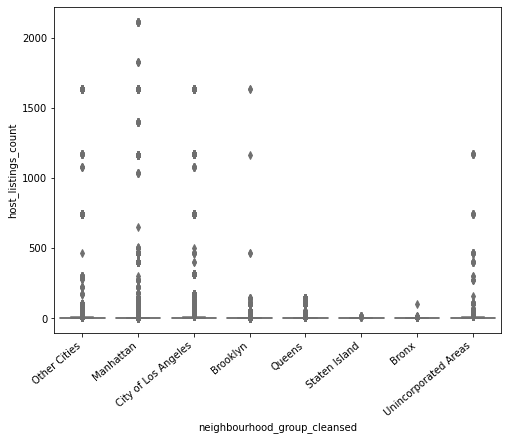

In [ ]:
plt.figure(figsize=(8,6))
bx = sns.boxplot(x='neighbourhood_group_cleansed',y='host_listings_count',data=listings_df,palette="pastel")
bx.set_xticklabels(bx.get_xticklabels(), rotation=40, ha="right")
plt.show()

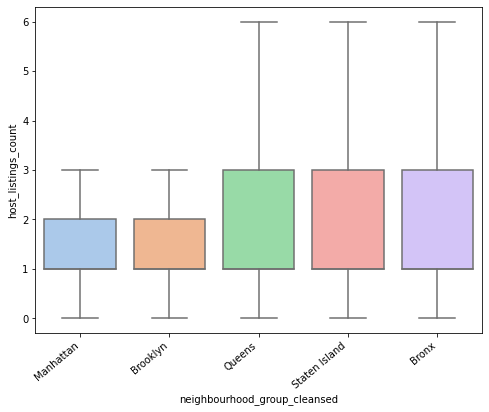

In [ ]:
plt.figure(figsize=(8,6))
bx = sns.boxplot(x='neighbourhood_group_cleansed',y='host_listings_count',data=listings_df[listings_df['city'] == 'NYC'],showfliers=False,palette="pastel")
bx.set_xticklabels(bx.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [ ]:
listings_df[listings_df['city'] == 'LA']['neighbourhood_cleansed'].nunique()

264

In [ ]:
# Take a look at differences between the neighborhood tags for LA and NYC
listings_df[listings_df['city'] == 'LA'][['neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed']]

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed
0,None,Culver City,Other Cities
2,"Los Angeles, California, United States",Hollywood,City of Los Angeles
3,"Santa Monica, California, United States",Santa Monica,Other Cities
4,"Bellflower, California, United States",Bellflower,Other Cities
11,"Los Angeles, California, United States",Del Rey,City of Los Angeles
...,...,...,...
75194,"Los Angeles, California, United States",Venice,City of Los Angeles
75195,None,Hollywood,City of Los Angeles
75196,None,Westwood,City of Los Angeles
75197,None,Westlake,City of Los Angeles


In [ ]:
# What are the average ratings? Looks like many are nearly perfect
listings_df.groupby('city')['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin'\
             ,'review_scores_communication','review_scores_location','review_scores_value'].describe()

# Comparing the two cities, LA has marginally better ratings across 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


review_scores_rating                             ... review_scores_value                  
                    count       mean       std   min  ...                 25%   50%   75%   max
city                                                  ...                                      
LA                23424.0  94.546277  9.236026  20.0  ...                 9.0  10.0  10.0  10.0
NYC               33102.0  93.849435  9.418724  20.0  ...                 9.0  10.0  10.0  10.0

[2 rows x 56 columns]

In [ ]:
# Worse reviews seem to correlate with lower number of reviews (makes sense)
listings_df[listings_df['review_scores_rating'] < 80][['number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness'\
                                                       ,'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']].describe()

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,2047.000000,2047.000000,2039.000000,2040.000000,2040.000000,2042.000000,2035.000000,2033.000000
mean,4.737665,58.026869,6.603237,6.200490,7.556373,7.197356,7.933661,6.307919
std,13.691585,18.393275,2.317745,2.326996,2.493888,2.519640,2.250974,2.162589
min,1.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,1.000000,50.000000,6.000000,5.000000,6.000000,6.000000,7.000000,6.000000
50%,2.000000,60.000000,7.000000,7.000000,8.000000,8.000000,9.000000,7.000000
75%,4.000000,73.000000,8.000000,8.000000,10.000000,9.000000,10.000000,8.000000
max,360.000000,79.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [ ]:
# Take a look at listings rated poorly
listings_df[listings_df['review_scores_rating'] < 80]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city
91,20300,https://www.airbnb.com/rooms/20300,2.020100e+13,10/6/2020,Great Location for NYC,Specious bed room with queen bed in convenienc...,The East Village is a diverse neighborhood wit...,https://a0.muscache.com/pictures/c54283a5-f4ea...,76627,https://www.airbnb.com/users/show/76627,Pas,2/2/2010,"New York, New York, United States",Social Ambassador of New York.,None,None,None,f,https://a0.muscache.com/im/pictures/user/6359c...,https://a0.muscache.com/im/pictures/user/6359c...,Alphabet City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"New York, United States",East Village,Manhattan,40.72912,-73.98057,Private room in apartment,Private room,2,None,1 bath,1.0,1.0,"[""Cable TV"", ""Essentials"", ""Heating"", ""Air con...",$50.00,1,730,1.0,1.0,730.0,730.0,1.0,730.0,None,t,0,0,0,0,10/6/2020,2,0,0,1/31/2016,2/14/2016,60.0,10.0,6.0,6.0,7.0,10.0,7.0,None,f,1,0,1,0,0.04,NYC
160,36442,https://www.airbnb.com/rooms/36442,2.020100e+13,10/7/2020,Great location. Spacious 2BR near PROSPECT PARK,"Spacious 2BR, 1 bathroom, dine-in kitchen and ...",None,https://a0.muscache.com/pictures/d38386da-ba9f...,137432,https://www.airbnb.com/users/show/137432,Paz,6/2/2010,"New York, New York, United States","Paz, from Brooklyn, New York.\r\nLoves a nice ...",None,None,0%,f,https://a0.muscache.com/im/users/137432/profil...,https://a0.muscache.com/im/users/137432/profil...,Prospect Heights,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,None,Prospect Heights,Brooklyn,40.67447,-73.96619,Entire apartment,Entire home/apt,4,None,1 bath,2.0,4.0,"[""Wifi"", ""Air conditioning"", ""Kitchen"", ""Hot w...",$121.00,15,60,15.0,15.0,60.0,60.0,15.0,60.0,None,t,0,0,4,279,10/7/2020,4,0,0,9/2/2012,8/27/2018,70.0,8.0,8.0,7.0,9.0,7.0,7.0,None,f,1,1,0,0,0.04,NYC
220,53137,https://www.airbnb.com/rooms/53137,2.020100e+13,10/12/2020,"Quiet, sunny Midtown Manhattan apt.","<b>The space</b><br />Sunny, 600-sq. foot one-...",None,https://a0.muscache.com/pictures/308493/4d9411...,240360,https://www.airbnb.com/users/show/240360,Marlaine,9/20/2010,"New York, New York, United States",I am a New York filmmaker/photographer/journa...,None,None,None,f,https://a0.muscache.com/im/users/240360/profil...,https://a0.muscache.com/im/users/240360/profil...,Hell's Kitchen,1.0,1.0,"['email', 'phone', 'reviews', 'offline_governm...",t,t,None,Hell's Kitchen,Manhattan,40.76244,-73.99271,Entire apartment,Entire home/apt,2,None,1 bath,1.0,2.0,"[""Dryer"", ""Heating"", ""Kitchen"", ""Washer"", ""Wifi""]",$195.00,5,20,5.0,5.0,20.0,20.0,5.0,20.0,None,t,30,60,90,365,10/12/2020,10,0,0,9/15/2018,7/1/2019,60.0,NaN,NaN,NaN,NaN,NaN,NaN,None,f,1,1,0,0,0.40,NYC
337,73246,https://ww

#### Format Listings Data

In [ ]:
# Drop columns we don't need
cols = pd.Series(listings_df.columns)

main_cols_drop = ['listing_url','scrape_id','last_scraped','picture_url','host_url','host_thumbnail_url',\
                  'host_picture_url','host_total_listings_count','host_verifications','neighbourhood','bathrooms',\
                  'calendar_updated', 'license','calendar_last_scraped','host_neighbourhood']

# drop all columns about minimum night except for 'minimum_nights'
night_cols_drop = list(cols[cols.apply(lambda x: '_nights' in x)])[1:]

# drop irrelevant availability columns
avail_cols_drop = list(cols[cols.apply(lambda x: 'availability' in x)])

# drop all reviews count columns except for 'number_of_reviews'
review_cols_drop = list(cols[cols.apply(lambda x: 'number_of_reviews_' in x)])

# drop host listing count by room type
listcount_cols_drop = list(cols[cols.apply(lambda x: 'calculated_host_listings_count' in x)])

# other features to drop
other_cols_drop = ['property_type', 'bathrooms_text', 'last_review', 'instant_bookable', 'reviews_per_month', 'host_id']

drop_cols = main_cols_drop + night_cols_drop + avail_cols_drop + review_cols_drop + listcount_cols_drop + other_cols_drop

listings_df.drop(columns=drop_cols, inplace=True)

In [ ]:
# Dates: host_since, first_review, last_review
listings_df['host_since']=listings_df['host_since'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
listings_df['first_review']=listings_df['first_review'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
# listings_df['last_review']=listings_df['last_review'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))

In [ ]:
# Percentages: host_response_rate, host_acceptance_rate
# Float: price
listings_df['host_response_rate']=listings_df['host_response_rate'].apply(lambda x: str(x).replace('%','') if not x else x)
listings_df['host_acceptance_rate']=listings_df['host_acceptance_rate'].apply(lambda x: str(x).replace('%','') if not x else x)
listings_df['price']=listings_df['price'].apply(lambda x: float(str(x).replace('$','').replace(',','')))

In [ ]:
listings_df['host_response_rate']=listings_df['host_response_rate'].apply(lambda x: float(x) if not x else x)
listings_df['host_acceptance_rate']=listings_df['host_acceptance_rate'].apply(lambda x: float(x) if not x else x)

In [ ]:
# Booleans: host_is_superhost, host_has_profile_pic, host_identity_verified, has_availability, instant_bookable
listings_df['host_is_superhost']=listings_df['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
listings_df['host_has_profile_pic']=listings_df['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
listings_df['host_identity_verified']=listings_df['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
# listings_df['has_availability']=listings_df['has_availability'].apply(lambda x: 1 if x == 't' else 0)
# listings_df['instant_bookable']=listings_df['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)

In [ ]:
# Rename: {'neighbourhood_cleansed':'neighborhood', 'neighbourhood_group_cleansed':'borough'}
# listings_df.rename(columns={'neighbourhood_cleansed':'neighborhood', 'neighbourhood_group_cleansed':'borough'},inplace=True)

In [ ]:
# Drop the 27 dud rows
listings_df.dropna(axis=0,subset={'host_name'},inplace=True)

In [ ]:
# Look at descriptions to see what needs cleaning
# pd.set_option('display.max_colwidth', -1)
listings_df[listings_df['description'].str.contains('<') == True]

,id,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city
0,109,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",None,Paolo,2008-06-27,"San Francisco, California, United States","Paolo Privitera, CEO Evensi\n\nPaolo, MIT MBA ...",None,None,0%,0,1.0,1,1,Culver City,Other Cities,33.98209,-118.38494,Entire home/apt,6,2.0,3.0,"[""TV"", ""Heating"", ""Cable TV"", ""Kitchen"", ""Sham...",115.0,30,2,2011-08-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,LA
1,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,70%,25%,0,6.0,1,1,Midtown,Manhattan,40.75362,-73.98377,Entire home/apt,2,NaN,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",175.0,3,48,2009-11-21,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NYC
2,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,Beautiful Furnished Mirror Mini-Suite w/ Firep...,We are minutes away from the Mentor Language I...,Chas.,2008-09-16,"Los Angeles, California, United States",Writer.\r\nLiterary Manager.\r\nPhotographer.\...,within a few hours,100%,100%,1,2.0,1,1,Hollywood,City of Los Angeles,34.09768,-118.34602,Private room,1,1.0,1.0,"[""Bed linens"", ""Essentials"", ""Patio or balcony...",75.0,30,27,2014-06-09,97.0,10.0,10.0,10.0,10.0,10.0,10.0,LA
3,2732,Zen Life at the Beach,An oasis of tranquility awaits you.<br /><br /...,"This is the best part of Santa Monica. Quiet, ...",Yoga Priestess,2008-09-17,"Santa Monica, California, United States",I have been teaching yoga and meditation for 3...,within an hour,92%,50%,0,2.0,1,1,Santa Monica,Other Cities,34.00475,-118.48127,Private room,1,1.0,1.0,"[""Hangers"", ""Refrigerator"", ""Dishes and silver...",155.0,1,21,2011-06-06,94.0,9.0,9.0,9.0,9.0,10.0,9.0,LA
4,2864,* Beautiful Master Suite/Jacuzzi Tub/*,Centrally located.... Furnished with King Size...,What makes the neighborhood unique is that the...,Bernadine,2008-09-25,"Bellflower, California, United States","Fair, open, honest and very informative for ne...",None,None,None,0,1.0,1,1,Bellflower,Other Cities,33.87619,-118.11397,Entire home/apt,2,1.0,1.0,"[""Bed linens"", ""Essentials"", ""TV"", ""Free stree...",50.0,30,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75193,45789220,Large house with Karaoke and Pool,"4-bedroom, 3-bath large home with most of Sout...",Very quite and safe neighborhood. Please do no...,Cassie,2017-06-19,"Las Vegas, Nevada, United States","World is so big, I would like to step on every...",within an hour,96%,95%,0,2.0,1,1,Rowland Heights,Unincorporated Areas,33.97066,-117.91884,Entire home/apt,10,4.0,7.0,"[""Bed linens"", ""Essentials"", ""Patio or balcony...",370.0,2,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LA
75194,45789403,✻ NEW Open Airy Single Bed Oasis in Venice Bea...,"Open and airy with high ceilings, the beautifu...","For those less familiar with Venice, it's a vi...",Marilyn,2012-07-14,"Venice Beach, California, United States","I'm a well-traveled, cultured art dealer and a...",within a few hours,100%,79%,1,2.0,1,1,Venice,City of Los Angeles,33.99456,-118.47314,Private room,1,1.0,1.0,"[""Essentials"", ""Patio or balcony"", ""Oven"", ""St...",69.0,2,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LA
75195,45789909,Bes

In [ ]:
def remove_bad_patterns(text):
    h = re.compile("(<.*?>)")
    n = re.compile("\n")
    r = re.compile("\r")
    t = re.compile("\t")
    l = re.compile("\$")
    
    text = h.sub("",text)
    text = n.sub(" ",text)
    text = r.sub(" ",text)
    text = t.sub(" ",text)
    text = l.sub(" ",text)

    return text

In [ ]:
# Clean descriptions of html tags and escape characters
listings_df['description'] = listings_df['description'].apply(lambda x: remove_bad_patterns(str(x)))
listings_df['host_about'] = listings_df['host_about'].apply(lambda x: remove_bad_patterns(str(x)))
listings_df['neighborhood_overview'] = listings_df['neighborhood_overview'].apply(lambda x: remove_bad_patterns(str(x)))

In [ ]:
# Remove unclosed breaks at end of descriptions
listings_df['description'] = listings_df['description'].apply(lambda x: str(x).replace('<br','').replace('<br /','').replace('<b','').replace('</b','').replace('</',''))
listings_df['host_about'] = listings_df['host_about'].apply(lambda x: str(x).replace('<br','').replace('<br /','').replace('<b','').replace('</b','').replace('</',''))
listings_df['neighborhood_overview'] = listings_df['neighborhood_overview'].apply(lambda x: str(x).replace('<br','').replace('<br /','').replace('<b','').replace('</b','').replace('</',''))

In [ ]:
listings_df['description']=listings_df['description'].apply(lambda x: str(x).replace('<','') if str(x)[-1] == '<' else x)
listings_df['host_about']=listings_df['host_about'].apply(lambda x: str(x).replace('<','') if str(x)[-1] == '<' else x)
listings_df['neighborhood_overview']=listings_df['neighborhood_overview'].apply(lambda x: str(x).replace('<','') if str(x)[-1] == '<' else x)

In [ ]:
# Check again -- only 14 left and the '<' seem legitimate
pd.set_option('display.max_colwidth', -1)
listings_df[listings_df['description'].str.contains('<') == True]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,id,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city
33980,22152984,Private Hillside Suite with a View,"This private 400sf suite in our home (we live on the level above) has an open floor plan w/ its own entrance & bathroom and sweeping views w/ space for up to 5 people (2 on king bed, 2 on sofa bed, 1 on air mattress). Kitchenette (microwave, toaster oven, pour-over coffee brewer, electric kettle, fridge w/ separate freezer, dishes/drinkware/utensils) is great for light food prep/reheating leftovers. Freshly ground coffee is provided at the beginning of your stay upon request. Free WiFi/Smart TV.The spaceClose to Rose Bowl, Dodgers Stadium, Staples Center, Trader Joe's, Target, downtown L.A., Griffith Park Observatory, many colleges, Hollywood and Universal Studios with easy access to two freeways. Nearby hospitals include Adventist Health Glendale and Glendale Memorial, Huntington in Pasadena, and St. Joseph's in Burbank. Closest airport is Burbank. If flying into LAX, you may want to consider taking the Flyaway Bus to Union Station in downtown L.A. (< 10 each","Nice homes in a safe neighborhood, we are in the hills with pleasant walks and great views. A mall with Macy's and Target is at the bottom of our hill, just a few minutes walking distance. A vibrant art scene comes alive on the second Saturday of each month with over 50 galleries nearby. The Rose Bowl is a short drive away and is a popular walking, jogging and biking destination for thousands of people every day. We are about an hour from Venice and Santa Monica beaches, Disneyland and Magic Mountain.",Steve And Kathy,2017-12-07,"Los Angeles, California, United States","It's been great to be able to work from home. When not recording voice over projects such as commercials and narrations, Steve works in graphic design and printing. He plays drums in a band (blues, jams and Rock 'n Roll), and participates in drum circles regularly for fun. Eating healthy and being active is important to him as is travel, attending festivals and art shows. Kathy is a Weight Watcher leader and also works at a hospital. She sews and is a wine aficionado. Just starting to host Airbnb and we look forward to meeting and helping fellow travelers. We're just as fine with respecting your privacy. The guest space is self check-in so you can come and go anytime without disturbing anyone.",within an hour,100%,100%,1,1.0,1,0,Eagle Rock,City of Los Angeles,34.13857,-118.22710,Entire home/apt,5,NaN,2.0,"[""Bed linens"", ""Essentials"", ""Patio or balcony"", ""TV"", ""Keypad"", ""Free street parking"", ""Hair dryer"", ""Laptop-friendly workspace"", ""Extra pillows and blankets"", ""Luggage dropoff allowed"", ""Air conditioning"", ""Hot water"", ""Wifi"", ""Carbon monoxide alarm"", ""Iron"", ""Private entrance"", ""Hangers"", ""Shampoo"", ""Dishes and silverware"", ""Free parking on premises"", ""Fire extinguisher"", ""Refrigerator"", ""First aid kit"", ""Heating"", ""Outlet covers"", ""Coffee maker"", ""Microwave"", ""Smoke alarm"", ""Long term stays allowed"", ""Room-darkening shades""]",86.0,2,76,2018-06-17,98.0,10.0,10.0,10.0,10.0,10.0,10.0,LA
36673,23781939,Upper West Side 2 Bedroom,"Steps away from Central Park, 123 & BC subway lines. <10 min walk to Lincoln Center & Columbus Circle.",None,Eliana,2014-10-22,"New York, New York, United States","Barnard grad, working in tech in NYC",None,None,None,0,2.0,1,1,Upper West Side,Manhattan,40.77907,-73.97887,Entire home/apt,4,2.0,2.0,"[""Laptop-frie

In [ ]:
# Scope check -- we're all good
pd.set_option('display.max_colwidth', 50)
listings_df[listings_df['description'].str.contains('<') == True]['id'].count()

14

In [ ]:
# Final look at listings dataset
listings_df[listings_df['city'] == 'NYC'].head()

,id,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city,coordinates,zipcodes
1,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a day,70%,25%,0,6.0,1,1,Midtown,Manhattan,40.75362,-73.98377,Entire home/apt,2,NaN,1.0,"[""Hot water"", ""Stove"", ""Extra pillows and blan...",175.0,3,48,2009-11-21,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NYC,"[40.75362, -73.98376999999999]",10110
5,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back Native New Yorker (formerly bi-coast...,within an hour,98%,96%,0,1.0,1,1,Clinton Hill,Brooklyn,40.68514,-73.95976,Entire home/apt,3,1.0,3.0,"[""Hot water"", ""Stove"", ""Free parking on premis...",76.0,1,354,2014-09-30,89.0,8.0,9.0,9.0,9.0,9.0,9.0,NYC,"[40.685140000000004, -73.95976]",11238
6,5121,BlissArtsSpace!,The spaceHELLO EVERYONE AND THANKS FOR VISITIN...,None,Garon,2009-02-03,"New York, New York, United States","I am an artist(painter, filmmaker) and curato...",None,None,100%,0,1.0,1,1,Bedford-Stuyvesant,Brooklyn,40.68688,-73.95596,Private room,2,1.0,1.0,"[""Wifi"", ""Air conditioning"", ""Heating"", ""Kitch...",60.0,29,50,2009-05-28,90.0,8.0,8.0,10.0,10.0,9.0,9.0,NYC,"[40.68688, -73.95596]",11216
7,5136,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,None,Rebecca,2009-02-03,"New York, New York, United States","Rebecca is an artist/designer, and Henoch is i...",within a few hours,100%,None,0,1.0,1,0,Sunset Park,Brooklyn,40.66120,-73.99423,Entire home/apt,4,2.0,2.0,"[""Wifi"", ""Dryer"", ""Air conditioning"", ""Kitchen...",175.0,7,1,2014-01-02,97.0,10.0,10.0,10.0,10.0,8.0,10.0,NYC,"[40.6612, -73.99423]",11215
8,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Shunichi,2009-03-03,"New York, New York, United States",I used to work for a financial industry but no...,within a few hours,100%,100%,0,1.0,1,0,Hell's Kitchen,Manhattan,40.76489,-73.98493,Private room,2,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""Paid ...",73.0,2,473,2009-05-06,84.0,9.0,7.0,9.0,9.0,10.0,9.0,NYC,"[40.76489, -73.98493]",10019


In [ ]:
# Obtain coordinates as one
location = geolocator.reverse((34.09768, -118.34602))
location.raw['address']['postcode']

'90046-4101'

In [ ]:
listings_df[listings_df['longitude']==-118.8053]
test

,id,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city,coordinates,zipcodes
158,33447,Malibu Guest house/ near beach,"The spaceLittle, mid century, ranch style, pri...",".2 of Mi to Little Dume Beach, one mile to Po...",Patricia,2010-06-15,"Malibu, California, United States",We love sharing our beautiful Point Dume Penin...,within a few hours,100%,86%,1,1.0,1,1,Malibu,Other Cities,34.01282,-118.80530,Entire home/apt,2,1.0,1.0,"[""TV"", ""Host greets you"", ""Wifi"", ""Single leve...",188.0,2,332,2010-07-12,99.0,10.0,10.0,10.0,10.0,10.0,10.0,LA,"34.01282, -118.8053",
159,35922,Luxury Beachfront Santa Monica Home,"My place is close to Venice, 3rd Street Promen...",None,Blu Santa Monica,2010-06-28,"Santa Monica, California, United States",None,within a day,60%,None,0,1.0,1,1,Santa Monica,Other Cities,34.00906,-118.49282,Entire home/apt,6,3.0,3.0,"[""TV"", ""Elevator"", ""Laptop-friendly workspace""...",900.0,31,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LA,"34.00906, -118.49282",90401


#### Get Zip Codes
Centroids data from: https://simplemaps.com/data/us-zips#anchor_centroid


In [ ]:
# What didn't work
def get_zipcode(df, geolocator, lat_field, lon_field, id):
  try:
    location = geolocator.reverse((df[lat_field], df[lon_field]), timeout=None)
    if 'postcode' in location.raw['address']:
      return location.raw['address']['postcode']
    else:
      return ''
  except GeocoderTimedOut as e:
    print("Error: geocode failed on input %s"%(df[id]))

geolocator = geopy.Nominatim(user_agent='my-application')

listings_df['zipcodes'] = listings_df.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='latitude', lon_field='longitude', id='id')

Error: geocode failed on input 182095
Error: geocode failed on input 8009332
Error: geocode failed on input 8861340


In [ ]:
# Obtain centroids lat/long pairing and convert to an array
centroids['centroids'] = centroids[['lat', 'lng']].values.tolist()
centroids_arr = np.array(centroids['centroids'].tolist())

In [ ]:
listings_df['coordinates'] = listings_df[['latitude','longitude']].values.tolist()

In [ ]:
# Create our kd-tree
kdt = cKDTree(centroids_arr)

In [ ]:
# Function to get zipcodes
def get_zipcode(kdt, coordinates):
  distance, index = kdt.query(coordinates)
  return centroids.loc[index,'zip']

In [ ]:
# Get zipcodes
listings_df['zipcodes'] = listings_df['coordinates'].apply(lambda x: get_zipcode(kdt,x))

In [ ]:
# QC: Keep only relevant columns
test=listings_df[listings_df['city'] == 'NYC'][['neighbourhood_cleansed','neighbourhood_group_cleansed','latitude','longitude','zipcodes']]

In [ ]:
# Merge listings with centroids to compare cities
test = test.merge(centroids,left_on='zipcodes',right_on='zip')[['neighbourhood_cleansed','neighbourhood_group_cleansed','latitude','longitude','zipcodes','city']]

In [ ]:
# Hmmm not looking great
test[test['neighbourhood_cleansed'] != test['city']][['neighbourhood_cleansed','city']]

,neighbourhood_cleansed,city
0,Midtown,New York
1,Midtown,New York
2,Midtown,New York
3,Midtown,New York
4,Midtown,New York
...,...,...
44644,Prince's Bay,Staten Island
44645,Rossville,Staten Island
44646,Bellerose,Floral Park
44647,Little Neck,Great Neck


In [ ]:
test[test['neighbourhood_cleansed'] == 'Culver City']

,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,zipcodes,city
0,Culver City,Other Cities,33.98209,-118.38494,90056,Los Angeles
11,Culver City,Other Cities,33.98350,-118.38368,90056,Los Angeles
12,Culver City,Other Cities,33.98303,-118.38609,90056,Los Angeles
23,Culver City,Other Cities,33.98231,-118.38567,90056,Los Angeles
31,Culver City,Other Cities,33.98182,-118.38535,90056,Los Angeles
...,...,...,...,...,...,...
45105,Culver City,Other Cities,34.01750,-118.40787,90034,Los Angeles
45107,Culver City,Other Cities,34.01578,-118.40988,90034,Los Angeles
45125,Culver City,Other Cities,34.01494,-118.41161,90034,Los Angeles
45169,Culver City,Other Cities,34.01612,-118.40900,90034,Los Angeles


In [ ]:
centroids[centroids['city'] == 'Culver City']

,zip,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone,centroids
30066,90230,33.99722,-118.39460,Culver City,CA,California,True,NaN,32808,2719.9,6037,Los Angeles,{'06037':100},Los Angeles,6037,False,False,America/Los_Angeles,"[33.99722, -118.3946]"
30067,90232,34.01879,-118.39182,Culver City,CA,California,True,NaN,14660,2777.2,6037,Los Angeles,{'06037':100},Los Angeles,6037,False,False,America/Los_Angeles,"[34.01879, -118.39182]"


In [ ]:
listings_df.to_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/listings_df_zip.csv', index=False)

### NYC Airbnb Reviews Data

In [ ]:
reviews_df = pd.read_csv('/content/sample_data/Inside Airbnb/reviews.csv')

In [ ]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2595,17857,11/21/2009,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
1,2595,19176,12/5/2009,53267,Cate,Great experience.
2,2595,19760,12/10/2009,38960,Anita,I've stayed with my friend at the Midtown Cast...
3,2595,34320,4/9/2010,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."
4,2595,46312,5/25/2010,117113,Alicia,We had a wonderful stay at Jennifer's charming...


In [ ]:
# Check data types -- looks like only 'date' needs to be formatted
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003064 entries, 0 to 1003063
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1003064 non-null  int64 
 1   id             1003064 non-null  int64 
 2   date           1003064 non-null  object
 3   reviewer_id    1003064 non-null  int64 
 4   reviewer_name  1003056 non-null  object
 5   comments       1002383 non-null  object
dtypes: int64(3), object(3)
memory usage: 45.9+ MB


#### Impact of nulls for key features

In [ ]:
# Check rows with null reviewer name
reviews_df[reviews_df['reviewer_name'].isna() == True] # Seems like it should be fine to keep these. They only relate to 3 distinct reviewers and comments are good

,listing_id,id,date,reviewer_id,reviewer_name,comments
816988,26519461,479009556,6/30/2019,67667870,NaN,An excellent staying option near Union Square ...
828960,27409329,531741166,9/18/2019,292409881,NaN,Everything is good and the host is so nice. Ev...
848810,28613110,601540786,2/3/2020,333021262,NaN,He was an amazing host. The place was extremel...
878773,30438271,487059566,7/13/2019,67667870,NaN,Top ranked for all short term stay location op...
906186,32661291,509463395,8/14/2019,67667870,NaN,A generally nice location around Manhattan!
978544,39204077,602052431,2/5/2020,333021262,NaN,"She was absolutely amazing. Very nice , answer..."
978547,39204077,604510054,2/11/2020,333021262,NaN,Great host
990331,40864085,604793859,2/12/2020,333021262,NaN,Amazing host . Beautiful home . Truly enjoyed ...


In [ ]:
# Check rows with null comments
reviews_df[reviews_df['comments'].isna() == True] # Only 681 out of 1m+, I think we can drop these

,listing_id,id,date,reviewer_id,reviewer_name,comments
2392,10452,545500226,10/12/2019,61828046,Kendra,NaN
4542,15711,217296687,12/8/2017,4894631,Pina,NaN
18172,58059,502414181,8/4/2019,192121422,Kenny,NaN
26256,77765,265874153,5/18/2018,393775,Kathy,NaN
27841,89621,241550772,3/9/2018,148158874,Gabriel,NaN
...,...,...,...,...,...,...
1000348,43700282,670990441,10/4/2020,367378315,Ogun,NaN
1001523,44236150,640859045,7/21/2020,344091255,Jovanni M,NaN
1001773,44336693,662107737,9/8/2020,302629578,Mafeer',NaN
1002270,44664792,657479865,8/28/2020,297501927,Shani,NaN


#### Peek at other features


In [ ]:
# See how many reviews top listings have
reviews_df.groupby('listing_id').size().loc[lambda x: x>100].sort_values(ascending=False) # Links to "num_of_reviews" in listings

listing_id
32678719    746
9145202     695
10101135    648
16276632    629
15262831    573
           ... 
18359426    101
18411056    101
19055440    101
5758234     101
41535260    101
Length: 2768, dtype: int64

In [ ]:
# Check formatting of name
reviews_df[reviews_df['reviewer_name'].str.contains('/') == True] # 194 names are concatenated, should be fine

,listing_id,id,date,reviewer_id,reviewer_name,comments
20036,62787,483045,8/29/2011,556904,Nicolas/Gaëlle,Being in Staten Island and take the ferry ever...
26896,82638,265314057,5/16/2018,18681042,Michelle/Riccardo,Great location and very large and comfortable ...
30545,113265,34557339,6/9/2015,31758600,Laila/Muna,The room was better then I expected!! It was v...
31657,126443,61015671,1/30/2016,25601350,Villas/Condos/Yachts,We had great experience. Apartment was very cl...
32625,135393,498383874,7/29/2019,261984157,Sandra/Onicka,Karen & Joshua are great hosts. They were alwa...
...,...,...,...,...,...,...
982686,39691514,602071538,2/5/2020,8642081,Flavio/Filipe,Vor ab: ich kann die Wohnung nicht empfehlen.\...
988287,40558009,589677160,1/6/2020,6830718,Denise/Mark,The space/size of apt was great. Comfortable a...
989937,40793629,644319882,7/30/2020,228426015,Sasha (SHE/HERS),Fab space÷ very clean and modern
992864,41401667,602333938,2/6/2020,299353388,Antonio/Gaelle,It’s pretty nice just as expected. The bathroo...


#### Format Reviews Data

In [ ]:
# Format date -- note that this takes a few minutes to run
reviews_df['date'] = reviews_df['date'].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))

In [ ]:
# Clean descriptions of html tags and escape characters
reviews_df['comments'] = reviews_df['comments'].apply(lambda x: remove_bad_patterns(str(x)))

## Sentiment Analysis

In [ ]:
# Keep columns to analyze
listings_sentiment_df = listings_df[['id','name','description','neighborhood_overview','host_name','host_about']].copy()

In [ ]:
# Obtain scores indicating how positive, neutral and negative a sentence is. Average to get a score for the paragraph.
def sent_tokenize_content(content):
  sid = SentimentIntensityAnalyzer()
  pos = []
  neu = []
  neg = []
  com = []

  sentences = tokenize.sent_tokenize(content)
  for i in range(len(sentences)):
    scores = sid.polarity_scores(sentences[i])
    pos.append(scores['pos'])
    neu.append(scores['neu'])
    neg.append(scores['neg'])
    com.append(scores['compound'])

  return [np.mean(pos),np.mean(neu),np.mean(neg),np.mean(com)]

In [ ]:
# Obtain tokens from a string
stopwords = set(stopwords.words('english')) 
def tokenize_content(content):
  tokens = nltk.word_tokenize(content)
  tokens = [x.lower() for x in tokens if x.isalpha() == True]
  tokens = [i for i in tokens if (i in stopwords) == False]

  return tokens

In [ ]:
def get_most_common(highest,lowest):
  # Tokenize and flatten the descriptions
  highest_tokens = [tokenize_content(i) for i in highest]
  highest_tokens = [j for i in highest_tokens for j in i]

  lowest_tokens = [tokenize_content(i) for i in lowest]
  lowest_tokens = [j for i in lowest_tokens for j in i]

  highest_counter = Counter()
  for word in highest_tokens:
      highest_counter[word] += 1

  lowest_counter = Counter()
  for word in lowest_tokens:
      lowest_counter[word] += 1

  difference_highest_counter = highest_counter - lowest_counter
  difference_lowest_counter = lowest_counter - highest_counter

  return difference_highest_counter, difference_lowest_counter

### Listing Sentiments: Neighborhood Overview

##### Sentiment scores of neighborhood overview descriptions

In [ ]:
listings_sentiment_df['nh_sent_scores'] = listings_sentiment_df['neighborhood_overview'].apply(lambda x: sent_tokenize_content(x))

In [ ]:
listings_sentiment_df['nh_pos'] = listings_sentiment_df['nh_sent_scores'].apply(lambda x: x[0])
listings_sentiment_df['nh_neu'] = listings_sentiment_df['nh_sent_scores'].apply(lambda x: x[1])
listings_sentiment_df['nh_neg'] = listings_sentiment_df['nh_sent_scores'].apply(lambda x: x[2])
listings_sentiment_df['nh_com'] = listings_sentiment_df['nh_sent_scores'].apply(lambda x: x[3])

##### Token Analysis: Neighborhood Overview

In [ ]:
# Analyze difference between highly-rated listings and not-so-highly-rated listings
highest_nh = list(listings_df[listings_df['review_scores_rating'] >= 90]['neighborhood_overview'])
lowest_nh = list(listings_df[listings_df['review_scores_rating'] < 90]['neighborhood_overview'])

In [ ]:
# Get the most common 20 words from each type
highest_nh_counter, lowest_nh_counter = get_most_common(highest_nh,lowest_nh)

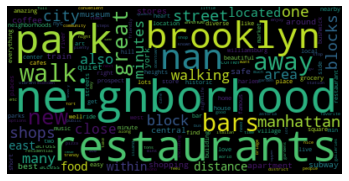

In [ ]:
highest_wordcloud = WordCloud().generate_from_frequencies(highest_nh_counter)
plt.imshow(highest_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

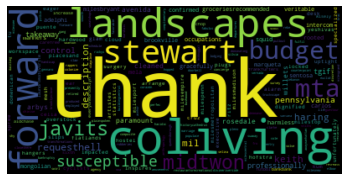

In [ ]:
lowest_wordcloud = WordCloud().generate_from_frequencies(lowest_nh_counter)
plt.imshow(lowest_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Listing Sentiments: Description of the Listing

##### Sentiment scores of listing descriptions

In [ ]:
listings_sentiment_df['desc_sent_scores'] = listings_sentiment_df['description'].apply(lambda x: sent_tokenize_content(x))

In [ ]:
listings_sentiment_df['desc_pos'] = listings_sentiment_df['desc_sent_scores'].apply(lambda x: x[0])
listings_sentiment_df['desc_neu'] = listings_sentiment_df['desc_sent_scores'].apply(lambda x: x[1])
listings_sentiment_df['desc_neg'] = listings_sentiment_df['desc_sent_scores'].apply(lambda x: x[2])
listings_sentiment_df['desc_com'] = listings_sentiment_df['desc_sent_scores'].apply(lambda x: x[3])

##### Token Analysis: Descriptions

In [ ]:
# Analyze difference between highly-rated listings and not-so-highly-rated listings
highest_desc = list(listings_df[listings_df['review_scores_rating'] >= 90]['description'])
lowest_desc = list(listings_df[listings_df['review_scores_rating'] < 90]['description'])

In [ ]:
# Get the most common 20 words from each type
highest_desc_counter, lowest_desc_counter = get_most_common(highest_desc,lowest_desc)

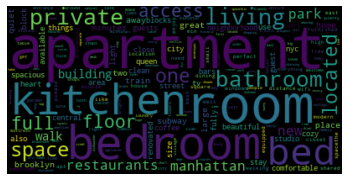

In [ ]:
highest_wordcloud = WordCloud().generate_from_frequencies(highest_desc_counter)
plt.imshow(highest_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

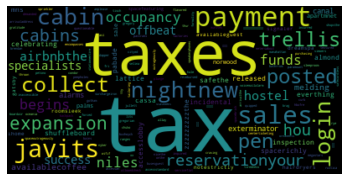

In [ ]:
lowest_wordcloud = WordCloud().generate_from_frequencies(lowest_desc_counter)
plt.imshow(lowest_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Listing Sentiments: Host "About"

##### Sentiment scores from host "about" descriptions

In [ ]:
listings_sentiment_df['host_sent_scores'] = listings_sentiment_df['host_about'].apply(lambda x: sent_tokenize_content(x))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [ ]:
listings_sentiment_df['host_pos'] = listings_sentiment_df['host_sent_scores'].apply(lambda x: x[0])
listings_sentiment_df['host_neu'] = listings_sentiment_df['host_sent_scores'].apply(lambda x: x[1])
listings_sentiment_df['host_neg'] = listings_sentiment_df['host_sent_scores'].apply(lambda x: x[2])
listings_sentiment_df['host_com'] = listings_sentiment_df['host_sent_scores'].apply(lambda x: x[3])

##### Token Analysis: Host "About"

In [ ]:
# Analyze difference between highly-rated listings and not-so-highly-rated listings
highest_host = list(listings_df[listings_df['review_scores_rating'] >= 90]['host_about'])
lowest_host = list(listings_df[listings_df['review_scores_rating'] < 90]['host_about'])

In [ ]:
# Get the most common 20 words from each type
highest_host_counter, lowest_host_counter = get_most_common(highest_host,lowest_host)

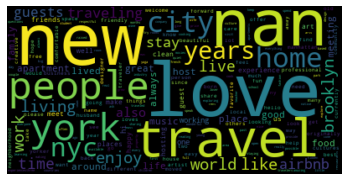

In [ ]:
highest_wordcloud = WordCloud().generate_from_frequencies(highest_host_counter)
plt.imshow(highest_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

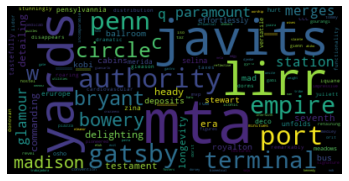

In [ ]:
lowest_wordcloud = WordCloud().generate_from_frequencies(lowest_host_counter)
plt.imshow(lowest_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Check to see if majority of review is English
# def check_english(text,english_vocab):
#   text = text.split()
#   text_vocab = set(w.lower() for w in text if w.lower().isalpha())
#   unusual = text_vocab.difference(english_vocab) 
#   if len(unusual) <= len(text_vocab)/2:
#     return 1
#   else:
#     return 0
# reviews_df['isEnglish'] = reviews_df['comments'].apply(lambda x: check_english(x,english_vocab))

### Assess Commonality of Names

We use the corpus of names from nltk to classify host names. Using this approach, we can infer that if the host name is in the corpus:
 

1.   We can assume it is relatively common.
2.   We can obtain the gender of the name.

If a name does not exist in the corpus, we assume that it is generally uncommon and we attempt to infer the gender based on whether the name ends in an 'a' or  'o'. 

In [ ]:
# Obtain common male and female names
male_names = names.words('male.txt')
female_names = names.words('female.txt')

# Standardize capitalization
male_names = [name.lower() for name in male_names]
female_names = [name.lower() for name in female_names]

In [ ]:
# Gets the gender of common names
def get_gender(names):
  if any(x.isupper() for x in names):
    names = re.findall('[A-Z][^A-Z]*',names)  # There are some names concatenated together that need filtering out
  names = [name.lower() for name in names]
  for name in names:
    if name in male_names:
      return 0
    elif name in female_names:
      return 1
  return -1

In [ ]:
# If a name isn't common, infer the gender based on whether a name ends in an 'a' or 'o'
def infer_gender(name):
  if name[-1] == 'a':
    return 1
  elif name[-1] == 'o':
    return 0
  else:
    return -1

##### Host Names

In [ ]:
# Obtain gender of common names: male=0; female=1; otherwise=-1
listings_sentiment_df['gender'] = listings_sentiment_df['host_name'].apply(lambda x: get_gender(x))

In [ ]:
# Classify names that contain multiple names/words
listings_sentiment_df['first_gender'] = listings_sentiment_df['host_name'].apply(lambda x: get_gender(x.lower().split()))

In [ ]:
# Combine gender classification
listings_sentiment_df['gender'] = np.where(listings_sentiment_df['gender']==-1, listings_sentiment_df['first_gender'],listings_sentiment_df['gender'])

In [ ]:
# If a name has been classified, mark it as common (1); otherwise, uncommon (0)
listings_sentiment_df['isCommon'] = listings_sentiment_df['gender'].apply(lambda x: 0 if x==-1 else 1)

In [ ]:
# Infer gender based on whether the name ends in an 'a' or 'o'
listings_sentiment_df['inferred_gender'] = listings_sentiment_df['host_name'].apply(lambda x: infer_gender(x.lower()))

In [ ]:
listings_sentiment_df['gender'] = np.where(listings_sentiment_df['isCommon']==0, listings_sentiment_df['inferred_gender'], listings_sentiment_df['gender'])

In [ ]:
# Unfortunately, it seems like we have a fair number of names that cannot be classified
listings_sentiment_df['gender'].value_counts()

 0    30815
 1    28820
-1    15537
Name: gender, dtype: int64

In [ ]:
# Take a look at the unclassified names: Generally, it does seem that the names are uncommon
# np.set_printoptions(threshold=sys.maxsize)
print(listings_sentiment_df[listings_sentiment_df['gender'] == -1]['host_name'].unique())

['Garon' 'Shunichi' 'Cyn' ... 'Johndavid' 'Hotel Fairfield Inn & Suites'
 'Nehemiah']


In [ ]:
# Drop intermediate columns
listings_sentiment_df.drop(columns={'nh_sent_scores','desc_sent_scores','host_sent_scores','first_gender','inferred_gender'},inplace=True)

In [ ]:
# pd.set_option('display.max_colwidth', -1)
listings_sentiment_df

,id,name,description,neighborhood_overview,host_name,host_about,nh_pos,nh_neu,nh_neg,nh_com,desc_pos,desc_neu,desc_neg,desc_com,host_pos,host_neu,host_neg,host_com,gender,isCommon
0,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,A New Yorker since 2000! My passion is creatin...,0.0710,0.8770,0.0520,0.17610,0.286000,0.710000,0.004000,0.801725,0.286000,0.714000,0.000,0.432650,1,1
1,3831,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,LisaRoxanne,Laid-back Native New Yorker (formerly bi-coast...,0.1325,0.8675,0.0000,0.50435,0.246429,0.736000,0.017571,0.370929,0.061500,0.938500,0.000,0.136600,1,1
2,5121,BlissArtsSpace!,The spaceHELLO EVERYONE AND THANKS FOR VISITIN...,nan,Garon,"I am an artist(painter, filmmaker) and curato...",0.0000,1.0000,0.0000,0.00000,0.195571,0.796786,0.007643,0.270364,0.251667,0.748333,0.000,0.590133,-1,0
3,5136,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,nan,Rebecca,"Rebecca is an artist/designer, and Henoch is i...",0.0000,1.0000,0.0000,0.00000,0.112375,0.873750,0.013875,0.309900,0.098667,0.901333,0.000,0.212300,1,1
4,5178,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.",Shunichi,I used to work for a financial industry but no...,0.0000,1.0000,0.0000,0.00000,0.084091,0.908727,0.007182,0.151391,0.000000,1.000000,0.000,0.000000,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44661,45724439,Clean Upper East Side Room for Women,The unit is located on the 3rd floor in Lennox...,nan,Tamara,nan,0.0000,1.0000,0.0000,0.00000,0.080375,0.919625,0.000000,0.094350,0.000000,1.000000,0.000,0.000000,1,1
44662,45725790,Idyllic Birds Eye View Escape in the LES,nan,nan,Marissa,I am the CEO and Founder/Producer at Mythologi...,0.0000,1.0000,0.0000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000,0.000000,1,1
44663,45726160,"Clean, bright 2BR steps from Prospect Park",Newly renovated 2 Bedroom apartment with great...,"The location is quiet and safe. Prospect Park,...",Mark,nan,0.1655,0.7850,0.0495,0.27360,0.270200,0.716800,0.013000,0.617200,0.000000,1.000000,0.000,0.000000,0,1
44664,45726522,big room for three,"Very clean Apartment , nice and cozy I have a...",nan,Celin,"Im a guy , easy going and chill person here (...",0.0000,1.0000,0.0000,0.00000,0.070750,0.914750,0.014500,0.169925,0.216500,0.719500,0.064,0.215450,-1,0


In [ ]:
listings_sentiment_df.to_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/listing_sentiments.csv')

In [ ]:
listings_sentiment_df.head()

,id,name,description,neighborhood_overview,host_name,host_about,nh_pos,nh_neu,nh_neg,nh_com,desc_pos,desc_neu,desc_neg,desc_com,host_pos,host_neu,host_neg,host_com,gender,isCommon
0,109,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",None,Paolo,"Paolo Privitera, CEO Evensi Paolo, MIT MBA (P...",0.000000,1.000000,0.000,0.000000,0.133000,0.867000,0.000000,0.407767,0.156300,0.843700,0.0,0.33563,0,1
1,2595,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,A New Yorker since 2000! My passion is creatin...,0.071000,0.877000,0.052,0.176100,0.286000,0.710000,0.004000,0.801725,0.286000,0.714000,0.0,0.43265,1,1
2,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,Beautiful Furnished Mirror Mini-Suite w/ Firep...,We are minutes away from the Mentor Language I...,Chas.,Writer. Literary Manager. Photographer. Pro...,0.102375,0.897625,0.000,0.134350,0.241500,0.758500,0.000000,0.548417,0.285300,0.714700,0.0,0.16697,-1,0
3,2732,Zen Life at the Beach,An oasis of tranquility awaits you.The spaceTh...,"This is the best part of Santa Monica. Quiet, ...",Yoga Priestess,I have been teaching yoga and meditation for 3...,0.607000,0.393000,0.000,0.636900,0.234250,0.765750,0.000000,0.454342,0.237333,0.762667,0.0,0.32760,-1,0
4,2864,* Beautiful Master Suite/Jacuzzi Tub/*,Centrally located.... Furnished with King Size...,What makes the neighborhood unique is that the...,Bernadine,"Fair, open, honest and very informative for ne...",0.049857,0.950143,0.000,0.022043,0.027667,0.953778,0.018556,0.019400,0.290250,0.709750,0.0,0.66165,1,1


##### Reviewer Names

In [ ]:
# Check for odd formattings
reviews_df[reviews_df['reviewer_name'].str.isalnum() == False].sort_values(by='reviewer_name')

,listing_id,id,date,reviewer_id,reviewer_name,comments
409267,9720768,604982004,2020-02-13,334212948,#F*6,Troy is really nice and considerate. The place...
801608,25460977,305617749,2018-08-11,23164840,#NAME?,Calm private space with easy access to the Sub...
400941,9394266,136100326,2017-03-08,109498090,#NAME?,"Si vous allez à New York, logez chez Antonia! ..."
109889,882559,223603492,2018-01-01,110692339,'Daniela,"Es un lugar con la mejor ubicación, muy gentil..."
772690,23702555,295617737,2018-07-24,38180545,'Daragh,The host canceled this reservation 24 days bef...
...,...,...,...,...,...,...
657939,19449463,454107160,2019-05-17,49842188,하 Ha,Thank you so much.
46243,232612,247177493,2018-03-27,24764171,하은 Haeun,"Dee’s place was amazing. Everything was clean,..."
912498,32964403,456800241,2019-05-22,24167738,혜민 (Henie),"쭝꾹 타운이라 꺽쩡하꼬 끼때또 안해서 끄런지, 쌩깍뽀따 좋았어요:) 호스트가 연락도..."
980709,39467771,555480680,2019-10-27,42163696,️Phoebe,This space is absolutely wonderful and was an ...


In [ ]:
# Just drop really odd names (i.e. '#F*6' or '#NAME?') -- only 3 of them
reviews_df = reviews_df[(reviews_df['reviewer_name'] != '#F*6') & (reviews_df['reviewer_name'] != '#NAME?')]

In [ ]:
reviews_df['reviewer_name']= reviews_df['reviewer_name'].apply(lambda x: str(x).replace('(','').replace(')',''))

In [ ]:
# Drop reviews with numeric names -- only 14 of them
reviews_df = reviews_df[reviews_df['reviewer_name'].str.isnumeric() == False]

In [ ]:
# Strip apostrophe from beginning of some names
reviews_df['reviewer_name']=reviews_df['reviewer_name'].apply(lambda x: x[1:] if x[0] == '\'' else x)

In [ ]:
# Drop reviews from "hidden" users (combining these two threw an error: will revisit)
reviews_df = reviews_df[reviews_df['reviewer_name'].str.contains('Airbnb','airbnb') == False]
reviews_df = reviews_df[reviews_df['reviewer_name'].str.contains('hidden','Hidden') == False]

In [ ]:
# Obtain gender of common names: male=0; female=1; otherwise=-1
reviews_df['gender'] = reviews_df['reviewer_name'].apply(lambda x: get_gender(x))

In [ ]:
# Classify names that contain multiple names/words
reviews_df['first_gender'] = reviews_df['reviewer_name'].apply(lambda x: get_gender(x.lower().split()))

In [ ]:
# Combine gender classification
reviews_df['gender'] = np.where(reviews_df['gender']==-1, reviews_df['first_gender'],reviews_df['gender'])

In [ ]:
# If a name has been classified, mark it as common (1); otherwise, uncommon (0)
reviews_df['isCommon'] = reviews_df['gender'].apply(lambda x: 0 if x==-1 else 1)

In [ ]:
# Infer gender based on whether the name ends in an 'a' or 'o'
reviews_df['inferred_gender'] = reviews_df['reviewer_name'].apply(lambda x: infer_gender(x.lower()))

In [ ]:
reviews_df['gender'] = np.where(reviews_df['isCommon']==0, reviews_df['inferred_gender'], reviews_df['gender'])

In [ ]:
# Unfortunately, it seems like we have a fair number of names that cannot be classified
reviews_df['gender'].value_counts()

 0    402516
 1    396693
-1    203594
Name: gender, dtype: int64

In [ ]:
# Drop intermediate columns
reviews_df.drop(columns={'first_gender','inferred_gender'},inplace=True)

## One-Hot Encoding

In [ ]:
listings_clean_df = pd.read_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/listing_cleaned.csv')
listings_sentiment_df = pd.read_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/listing_sentiments.csv')
reviews_df = pd.read_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/reviews_name.csv')

In [ ]:
listings_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44649 entries, 0 to 44648
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            44649 non-null  int64  
 1   name                          44633 non-null  object 
 2   description                   43368 non-null  object 
 3   neighborhood_overview         28193 non-null  object 
 4   host_name                     44649 non-null  object 
 5   host_since                    44649 non-null  object 
 6   host_location                 44524 non-null  object 
 7   host_about                    26792 non-null  object 
 8   host_response_time            21587 non-null  object 
 9   host_response_rate            21587 non-null  float64
 10  host_acceptance_rate          27801 non-null  float64
 11  host_is_superhost             44649 non-null  int64  
 12  host_listings_count           44649 non-null  float64
 13  h

In [ ]:
listings_clean_df.sort_values(by='host_since')

,id,name,description,neighborhood_overview,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
23592,23669201,Great Price: Williamsburg Brooklyn Loft off L ...,"1,100 sq. ft Loft between Williamsburg and Bu...",Old Italian neighborhood that is now gentrifie...,Tasos,2008-08-22,"New York, New York, United States",NaN,NaN,NaN,NaN,0,0.0,1,1,Williamsburg,Brooklyn,Entire home/apt,4,2.0,2.0,"[""Laptop-friendly workspace"", ""Essentials"", ""B...",120.0,45,1,2018-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1850,1101224,THE PUTNAM-3 Bdrm w/Outdoor Zen space/washer&d...,"The spaceB/c of current events, we've lowered ...",NaN,Teedo,2008-08-27,"Brooklyn, New York, United States",We shared our previous penthouse apartment wit...,within a day,100.0,71.0,1,1.0,1,1,Bedford-Stuyvesant,Brooklyn,Entire home/apt,4,3.0,3.0,"[""Wifi"", ""Dryer"", ""Air conditioning"", ""Patio o...",111.0,12,32,2013-07-01,98.0,10.0,10.0,10.0,10.0,9.0,10.0
16985,17263207,Corona free and clean. Liguria room.,*Clean and comfortable room with twin bed for ...,"Quiet, tree lined residential area with amenit...",John,2008-09-07,"New York, New York, United States",Educated professional living in Brooklyn. I l...,within an hour,100.0,91.0,1,7.0,1,0,Bensonhurst,Brooklyn,Private room,1,1.0,1.0,"[""Hot water"", ""Stove"", ""Free parking on premis...",99.0,1,24,2017-04-19,98.0,10.0,9.0,10.0,10.0,9.0,9.0
18202,18821462,"Sweet Spot 2: Calm, Clean, Accessible/Manhattan",Very well-appointed bedrooms. Bright with exc...,"Excellent location: very safe, clean, pretty, ...",Matthew,2008-09-07,"New York, New York, United States",The Basics: Outgoing. Curious. Social. Consci...,within a day,90.0,60.0,1,2.0,1,1,Upper East Side,Manhattan,Private room,1,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""First...",95.0,28,11,2017-09-07,96.0,9.0,9.0,9.0,10.0,10.0,10.0
16202,16331974,"Sweet Spot 1: Calm, Clean, & Accessible/Manhattan",Very well-appointed bedroom. Bright with exce...,"Excellent location: very safe, clean, pretty, ...",Matthew,2008-09-07,"New York, New York, United States",The Basics: Outgoing. Curious. Social. Consci...,within a day,90.0,60.0,1,2.0,1,1,Upper East Side,Manhattan,Private room,1,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""Kitch...",95.0,28,8,2017-01-05,93.0,10.0,9.0,10.0,10.0,10.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44489,45650616,Gramercy Best! 22nd & Second Ave!,Wonderful bright and clean apartment located i...,"Union Square, Gramercy's BEST! SECOND AVE & 22...",Sara,2020-09-29,US,NaN,NaN,NaN,NaN,0,0.0,1,1,Gramercy,Manhattan,Entire home/apt,6,1.0,2.0,"[""Sound system with Bluetooth and aux"", ""Hot w...",89.0,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44549,45675368,Diamond lockbox,This cozy and quiet one bedroom apartment is l...,NaN,Antonio,2020-09-30,US,NaN,NaN,NaN,NaN,0,1.0,1,1,Chinatown,Manhattan,Entire home/apt,1,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""First...",80.0,30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44527,45670897,A well sanitized cozy space for your relaxation,NaN,NaN,Pascal,2020-09-30,US,NaN,NaN,NaN,NaN,0,1.0,1,1,Hollis,Queens,Entire home/apt,2,1.0,1.0,"[""Wifi"", ""Hangers"", ""Air conditioning"", ""Priva...",120.0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44568,45688770,Taxpayers Studios Venue Only,"Large Event Space. For small gatherings., Smok...",NaN,Timothy,2020-10-01,"Brooklyn, New York, United States",NaN,NaN,NaN,100.0,0,1.0,1,1,Bushwick,Brooklyn,Private room,16,NaN,0.0,"[""Wifi"", ""A

In [ ]:
# listings_sentiment_df.to_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/listing_sentiments.csv')
# reviews_df.to_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/reviews_name.csv')

In [ ]:
listings_ml_df=listings_df.reset_index()

### Host Response Time

In [ ]:
host_response_time=pd.get_dummies(listings_ml_df['host_response_time']).reset_index()

In [ ]:
listings_ml_df=listings_ml_df.merge(host_response_time,left_on='index',right_on='index')

### Room Type


In [ ]:
room_type=pd.get_dummies(listings_ml_df['room_type']).reset_index()

In [ ]:
listings_ml_df=listings_ml_df.merge(room_type,left_on='index',right_on='index')

### Neighborhood Group

In [ ]:
nh_group=pd.get_dummies(listings_ml_df['neighbourhood_group_cleansed']).reset_index()

In [ ]:
listings_ml_df=listings_ml_df.merge(nh_group,left_on='index',right_on='index')

### Amenities

In [ ]:
# Get full list of amenities
amenities = {}
for i in range(len(listings_ml_df)):
  am=listings_ml_df['amenities'][i].replace('"','').replace('[','').replace(']','').lower().split(',')
  for j in range(len(am)):
    if am[j].strip() not in amenities.keys():
      amenities[am[j].strip()] = 1
    else:
      amenities[am[j].strip()] += 1

In [ ]:
# Get the top 20 most common amenities
top_amenities = Counter(amenities).most_common(20)
top_amenities = [x[0] for x in top_amenities]

In [ ]:
# Insert top 20 amenities as columns
for i in top_amenities:
  listings_ml_df.insert(len(listings_ml_df.columns), i, [0]*len(listings_ml_df), True) 

In [ ]:
# Manual one-hot encoding because Colab hates me
for i in range(len(listings_ml_df)):
  amenities=listings_ml_df['amenities'][i].replace('"','').replace('[','').replace(']','').lower().split(',')
  for j in range(len(amenities)):
    amenity = amenities[j].strip()
    if amenity in top_amenities:
      listings_ml_df[amenity][i] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Obtain Final Dataframe

In [ ]:
listings_sentiment_df.rename(columns={'Unnamed: 0':'index'},inplace=True)

In [ ]:
listings_sentiment_df.drop(columns={'name','description','neighborhood_overview','host_name','host_about'},inplace=True)

In [ ]:
# listings_ml_df=listings_ml_df.merge(listings_sentiment_df,left_on='id',right_on='id').drop(columns={'index','name','description','neighborhood_overview','host_name',\
#                                                                                      'host_about','host_response_time','host_location','room_type','amenities',\
#                                                                                      'neighbourhood_cleansed','neighbourhood_group_cleansed'})

listings_ml_df=listings_ml_df.merge(listings_sentiment_df,left_on='id',right_on='id').drop(columns={'name','neighborhood_overview','host_name',\
                                                                                     'host_response_time','host_location','room_type','amenities',\
                                                                                     'neighbourhood_cleansed','neighbourhood_group_cleansed'})

In [ ]:
listings_ml_df.head(5)

,index,id,description,host_since,host_about,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,price,minimum_nights,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,city,a few days or more,within a day,within a few hours,within an hour,Entire home/apt,Hotel room,Private room,Shared room,Bronx,Brooklyn,City of Los Angeles,Manhattan,Other Cities,Queens,Staten Island,Unincorporated Areas,wifi,essentials,heating,smoke alarm,kitchen,air conditioning,hangers,carbon monoxide alarm,tv,shampoo,hair dryer,laptop-friendly workspace,iron,hot water,washer,dryer,refrigerator,dishes and silverware,fire extinguisher,microwave,nh_pos,nh_neu,nh_neg,nh_com,desc_pos,desc_neu,desc_neg,desc_com,host_pos,host_neu,host_neg,host_com,gender,isCommon
0,0,109,"*** Unit upgraded with new bamboo flooring, br...",2008-06-27,"Paolo Privitera, CEO Evensi Paolo, MIT MBA (P...",None,0%,0,1.0,1,1,6,2.0,3.0,115.0,30,2,2011-08-15,80.0,10.0,10.0,6.0,8.0,10.0,8.0,LA,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,0.000000,1.000000,0.000,0.000000,0.133000,0.867000,0.000000,0.407767,0.156300,0.843700,0.0,0.33563,0,1
1,1,2595,"Beautiful, spacious skylit studio in the heart...",2008-09-09,A New Yorker since 2000! My passion is creatin...,70%,25%,0,6.0,1,1,2,NaN,1.0,175.0,3,48,2009-11-21,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NYC,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,1,1,1,0,0.071000,0.877000,0.052,0.176100,0.286000,0.710000,0.004000,0.801725,0.286000,0.714000,0.0,0.43265,1,1
2,2,2708,Beautiful Furnished Mirror Mini-Suite w/ Firep...,2008-09-16,Writer. Literary Manager. Photographer. Pro...,100%,100%,1,2.0,1,1,1,1.0,1.0,75.0,30,27,2014-06-09,97.0,10.0,10.0,10.0,10.0,10.0,10.0,LA,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0.102375,0.897625,0.000,0.134350,0.241500,0.758500,0.000000,0.548417,0.285300,0.714700,0.0,0.16697,-1,0
3,3,2732,An oasis of tranquility awaits you.The spaceTh...,2008-09-17,I have been teaching yoga and meditation for 3...,92%,50%,0,2.0,1,1,1,1.0,1.0,155.0,1,21,2011-06-06,94.0,9.0,9.0,9.0,9.0,10.0,9.0,LA,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0,1,0,0,1,1,0,0,0,1,1,1,1,0,1,0.607000,0.393000,0.000,0.636900,0.234250,0.765750,0.000000,0.454342,0.237333,0.762667,0.0,0.32760,-1,0
4,4,2864,Centrally located.... Furnished with King Size...,2008-09-25,"Fair, open, honest and very informative for ne...",None,None,0,1.0,1,1,2,1.0,1.0,50.0,30,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LA,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,0.049857,0.950143,0.000,0.022043,0.027667,0.953778,0.018556,0.019400,0.290250,0.709750,0.0,0.66165,1,1


In [ ]:
listings_ml_df.to_csv('/content/drive/Shared drives/CIS545: AirBnB/Data/listings_ml.csv', index=False)